In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies = pd.read_csv("ml-25m/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


Create search Engine

In [3]:
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [4]:
#Create new column called "clean_title"
movies["clean_title"] =movies["title"].apply(clean_title)


Create Search Engine
Convert out titles into sets of numbers so they can be searched

Create Search Engine
Convert out titles into sets of numbers so they can be searched

We're using a Term Frequency Matrix
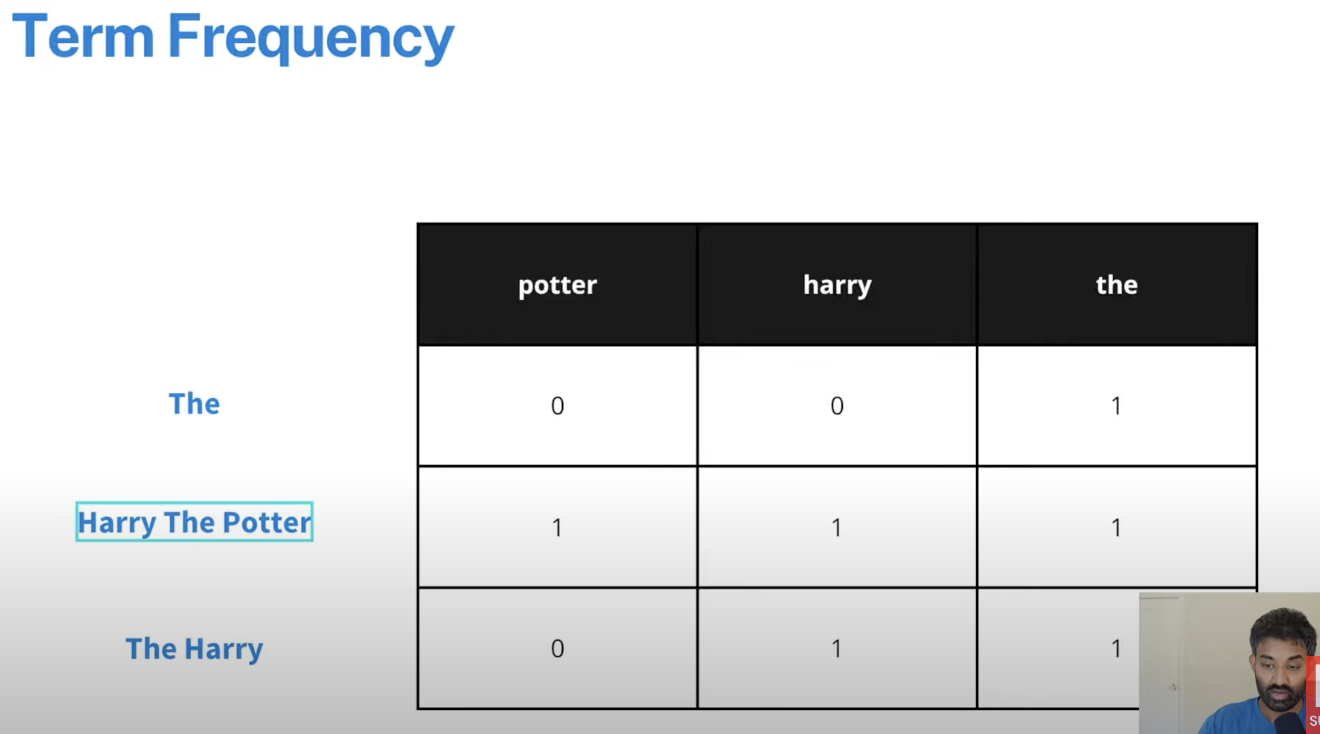

At the end, we get a set of numbers to represent a title and it compares it to all the other titles in the data
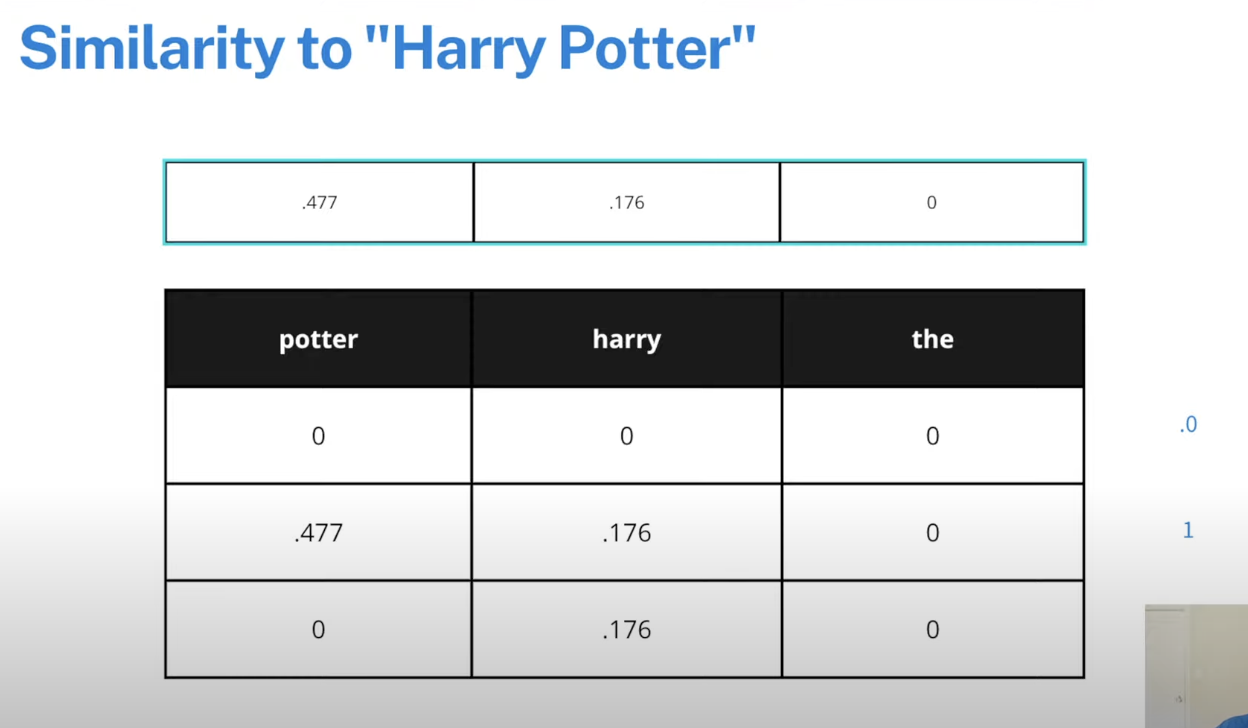

In [5]:
#Term Frequency is implemented through scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#ngram_range makes Tf search for "Toy", "Story" and "1995"
#but also for "Toy Story" and "Story 1995"
vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Turn about set of titles into a matrix
tfidf = vectorizer.fit_transform(movies["clean_title"])

In [6]:
#COmpute the similarity between the term that we enter and all of 
#the movies on the list using cosine-similarity

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])

    #Compare the query term to each of the titles in the df
    #and return how similar it is to each
    similarity = cosine_similarity(query_vec, tfidf).flatten()

    #find 5 titles with greatest similarities
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]

    return results

In [7]:
check = search("Cinderella")
check

,movieId,title,genres,clean_title
27753,130073,Cinderella (2015),Children|Drama|Fantasy|Romance,Cinderella 2015
36297,149883,Cinderella (2000),(no genres listed),Cinderella 2000
27427,129195,Cinderella (2011),Drama|Romance,Cinderella 2011
48189,176143,Cinderella (2012),Comedy|Romance,Cinderella 2012
60506,203467,Cinderella (2006),Drama|Horror|Mystery|Thriller,Cinderella 2006


Build Interactive Search

In [8]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()

        #essentially the input from the widget
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

Get Recommendations for movies that we liked

In [9]:
ratings=pd.read_csv('ml-25m/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [10]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Lets find users who liked the same movies

In [11]:
#id for Toy Story
movie_id = 1

#So we're finding anyone who watched and  liked Toy Story (aka 5/5), 
#and find their user ids (unique ones)
similar_users = ratings[(ratings["movieId"]==movie_id) & (ratings["rating"] >= 5)]["userId"].unique()
similar_users

array([    36,     75,     86, ..., 162518, 162519, 162530])

In [12]:
#Now lets find the other movies that they like

#This helps us filter the ratings_df for the ratings provided by 
#the people who also like Toy Story and find any of their recommendations
#that were also 5/5, we are getting the IDs of those movies
#these ids can be used as keys to get to the movie names
similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
similar_user_recs

5101           1
5105          34
5111         110
5114         150
5127         260
            ... 
24998388    3706
24998389    3735
24998391    3763
24998392    4187
24998393    4321
Name: movieId, Length: 912084, dtype: int64

In [13]:
#Now we'll only get the movies that more than 10% of the similar users
#also liked
similar_user_recs.value_counts() / len(similar_users)

1         1.000000
318       0.414556
260       0.404561
356       0.347253
296       0.342663
            ...   
27306     0.000074
71732     0.000074
4739      0.000074
190187    0.000074
97957     0.000074
Name: movieId, Length: 16797, dtype: float64

That means that all of those users liked movieID 1 (Toy story), 41.45% like movieID 318 and 40.4% liked movieID 260

In [14]:
#Now we only want the ones that are above 10%
best_recs = similar_user_recs.value_counts() / len(similar_users) 
best_recs = best_recs[best_recs > .10]
best_recs

1       1.000000
318     0.414556
260     0.404561
356     0.347253
296     0.342663
          ...   
1259    0.102991
7361    0.101881
1206    0.101362
1307    0.101066
1208    0.100918
Name: movieId, Length: 92, dtype: float64

Now we want to find similar movies from these users that are similar to your interests. 

In [15]:
#Find anyone that has rated a movie that is in our recommended set
#of movies and find anyone who's rated them highly
all_users = ratings[(ratings["movieId"].isin(best_recs.index)) & (ratings["rating"] > 4)]
all_users

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
29,1,4973,4.5,1147869080
48,1,7361,5.0,1147880055
72,2,110,5.0,1141416589
76,2,260,5.0,1141417172
...,...,...,...,...
25000055,162541,4973,4.5,1240950790
25000057,162541,4993,5.0,1240952610
25000065,162541,5952,5.0,1240952617
25000078,162541,7153,5.0,1240952613


In [16]:
#find what percentage of users recommend all these movies
all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
all_user_recs

318      0.345282
296      0.287220
2571     0.246217
356      0.237370
593      0.227930
           ...   
1387     0.047886
1307     0.046195
745      0.037362
78499    0.035445
2355     0.025316
Name: movieId, Length: 92, dtype: float64

Create Recommendation Score

In [17]:
rec_percentages = pd.concat([best_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages

,similar,all
1,1.000000,0.125844
318,0.414556,0.345282
260,0.404561,0.224195
356,0.347253,0.237370
296,0.342663,0.287220
...,...,...
1259,0.102991,0.049349
7361,0.101881,0.105172
1206,0.101362,0.087500
1307,0.101066,0.046195


In [18]:
#We want movies that have a big difference between similar and all
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages

,similar,all,score
1,1.000000,0.125844,7.946323
318,0.414556,0.345282,1.200632
260,0.404561,0.224195,1.804507
356,0.347253,0.237370,1.462916
296,0.342663,0.287220,1.193030
...,...,...,...
1259,0.102991,0.049349,2.087002
7361,0.101881,0.105172,0.968704
1206,0.101362,0.087500,1.158430
1307,0.101066,0.046195,2.187804


In [19]:
rec_percentages = rec_percentages.sort_values("score", ascending=False)
rec_percentages

,similar,all,score
1,1.000000,0.125844,7.946323
3114,0.295498,0.054186,5.453383
2355,0.124685,0.025316,4.925186
78499,0.138161,0.035445,3.897906
588,0.233674,0.068117,3.430480
...,...,...,...
58559,0.160743,0.147779,1.087725
79132,0.129424,0.132559,0.976349
7361,0.101881,0.105172,0.968704
2959,0.205020,0.218656,0.937638


In [20]:
#the higher the score, the better the recommendation
#we'll take the top 10 and find the corresponding movies
rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")

,similar,all,score,movieId,title,genres,clean_title
0,1.000000,0.125844,7.946323,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
3021,0.295498,0.054186,5.453383,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 2 1999
2264,0.124685,0.025316,4.925186,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,Bugs Life A 1998
14813,0.138161,0.035445,3.897906,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,Toy Story 3 2010
580,0.233674,0.068117,3.430480,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,Aladdin 1992
587,0.198949,0.060514,3.287671,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,Beauty and the Beast 1991
33,0.158226,0.052696,3.002602,34,Babe (1995),Children|Drama,Babe 1995
4780,0.210647,0.071444,2.948410,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,Monsters Inc 2001
1047,0.143418,0.049202,2.914882,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,Willy Wonka the Chocolate Factory 1971
729,0.108322,0.037362,2.899227,745,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy,Wallace Gromit A Close Shave 1995


Create function to do recommendation

In [21]:
def find_similar_movies(movie_id):

    #first find users similar to us
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    #find all of the users and their recommendations
    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    #calculation our scores and sorting them
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

In [22]:
import ipywidgets as widgets
from IPython.display import display

movie_name_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

Text(value='Toy Story', description='Movie Title:')

Output()